# **PyDMD: Dynamic Mode Decomposition with Python**

By the end of this tutorial, users should be able to...
- Build and fit basic `BOPDMD` models (optimized DMD with bagging).
- Access and understand crucial DMD model attributes.
- Visualize DMD results with the `plot_summary` function.

## **Part 0: Installing PyDMD**

To ensure that you are working with the most recent version of PyDMD, we recommend that users install directly from the [Github source code](https://github.com/PyDMD/PyDMD).

One can do so by running the following line of code:

In [ ]:
!pip install git+https://github.com/PyDMD/PyDMD.git

  Cloning https://github.com/PyDMD/PyDMD.git to /tmp/pip-req-build-c9jdh04j
  Running command git clone --filter=blob:none --quiet https://github.com/PyDMD/PyDMD.git /tmp/pip-req-build-c9jdh04j
  Resolved https://github.com/PyDMD/PyDMD.git to commit 1dfd80eacb4ba078bf04a2ccd88e79f53a305cd2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


## **Part 1: Make the Toy Data Set**

In this tutorial, we apply DMD to a simple synthetic data set with added Gaussian noise.

Run the following block of code to import `numpy`, `matplotlib`, and a helper function that we will be providing.

In [ ]:
# Be sure to install numpy and matplotlib if needed.
# !pip install numpy
# !pip install matplotlib
import numpy as np
import matplotlib.pyplot as plt

def compute_error(actual, truth):
    """
    Args:
        actual = numpy.ndarray of computed values
        truth = numpy.ndarray of expected values
    Returns:
        Relative error as a percentage
    """
    return 100 * np.linalg.norm(truth - actual) / np.linalg.norm(truth)

We examine data derived from the system $f(x, t) = f_1(x, t) + f_2(x, t)$, where<br>

$f_1(x, t) = \text{sech}(x + 3) e^{i 2.3 t}$<br>
$f_2(x, t) = 2\text{sech}(x) \text{tanh}(x) e^{i 2.8 t}$.

We specifically examine the domain $x \in [-5, 5]$ across times $t \in [0, 4\pi]$, where we have access to $n = 65$ spatial collocation points across $m = 129$ snapshots (all evenly-spaced). We then pollute the data with Gaussian noise for added realism.

Run the code below to build this particular data set.



In [ ]:
def f1(x, t):
    """
    Spatiotemporal mode 1.
    """
    return 1.0 / np.cosh(x + 3) * np.exp(1j * 2.3 * t)

def f2(x, t):
    """
    Spatiotemporal mode 2.
    """
    return 2.0 / np.cosh(x) * np.tanh(x) * np.exp(1j * 2.8 * t)

nx = 65  # number of grid points along space dimension
nt = 129  # number of grid points along time dimension

# Define the space and time grid for data collection.
x = np.linspace(-5, 5, nx)
t = np.linspace(0, 4 * np.pi, nt)
xgrid, tgrid = np.meshgrid(x, t)

# Data consists of our 2 spatiotemporal signals.
X1 = f1(xgrid, tgrid).T
X2 = f2(xgrid, tgrid).T
X = X1 + X2

# Generate noisy data.
noise_magnitude = 0.2
noise = noise_magnitude * (1 + 1j) * np.random.randn(*X.shape)
X_noisy = X + noise

# Print data information.
print("Data successfully generated!")
print(f"X.shape (state, time) = {X.shape}")
print(f"t.shape (time,) = {t.shape}")
print()
dx = np.round(x[1] - x[0], decimals=3)
dt = np.round(t[1] - t[0], decimals=3)
print(f"Space Discretization: [{x[0]}, {x[-1]}], dx = {dx}")
print(f"Time Discretization: [{t[0]}, {np.round(t[-1], decimals=5)}], dt = {dt}")

Data successfully generated!
X.shape (state, time) = (65, 129)
t.shape (time,) = (129,)

Space Discretization: [-5.0, 5.0], dx = 0.156
Time Discretization: [0.0, 12.56637], dt = 0.098


We now visualize the data (real components) with the following code.

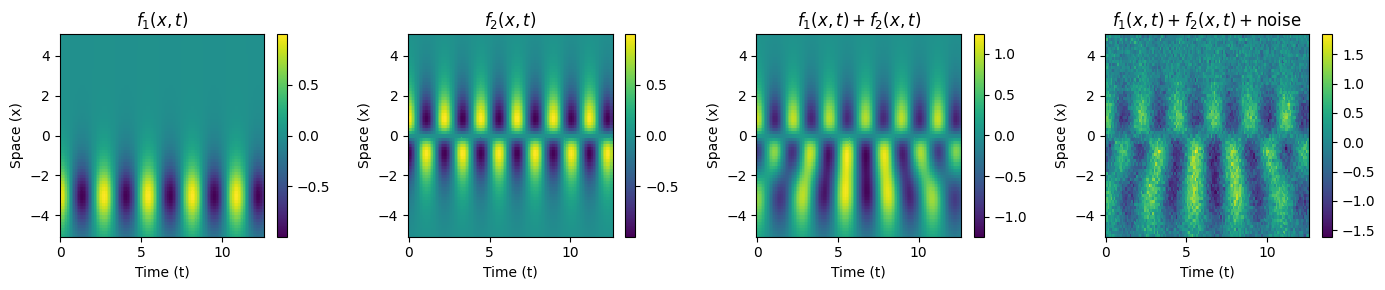

In [ ]:
# Visualize the data.
titles = [
    "$f_1(x,t)$",
    "$f_2(x,t)$",
    "$f_1(x,t)+f_2(x,t)$",
    "$f_1(x,t)+f_2(x,t)+$noise",
]
data = [X1, X2, X, X_noisy]

fig = plt.figure(figsize=(14, 3))
for i, (title, d) in enumerate(zip(titles, data)):
    plt.subplot(1, 4, i + 1)
    plt.title(title)
    plt.pcolor(tgrid, xgrid, d.real.T)
    plt.xlabel("Time (t)")
    plt.ylabel("Space (x)")
    plt.colorbar()

plt.tight_layout()
plt.show()

To give users a better sense of what this data set looks like, we provide the following animation of the data.

Feel free to skip this cell if you simply wish to proceed.

In [ ]:
# Be sure to install moviepy if needed.
# !pip install moviepy

# NOTE: moviepy requires matplotlib<3.10:
# !pip install matplotlib==3.9.0

from moviepy.editor import *
from moviepy.video.io.bindings import mplfig_to_npimage

# colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]
# titles = [
#     "$f_1(x,t)$",
#     "$f_2(x,t)$",
#     "$f_1(x,t)+f_2(x,t)$",
#     "$f_1(x,t)+f_2(x,t)+$noise",
# ]

# def make_video(data, T, name):
#     fps = int(X.shape[1] / T)

#     def make_frame(ti):
#         time_index = int(fps * ti)
#         for i, (ax, mat) in enumerate(zip(axes, data)):
#             ax.clear()
#             plt.suptitle(f"t = {np.round(t[time_index], decimals=5)}")
#             ax.plot(x, mat[:, time_index].real, c=colors[i])
#             ax.set_ylim([-1.6, 1.6])
#             ax.set_title(titles[i])
#             ax.set_xlabel("x")
#             ax.grid()
#             # ax.set_yticks([])
#         plt.tight_layout()
#         return mplfig_to_npimage(fig)

#     fig, axes = plt.subplots(1, 4, figsize=(10, 3))
#     animation = VideoClip(make_frame, duration=T)
#     animation.write_videofile(name, fps=fps)

# # Make the mp4 file.
# make_video([X1, X2, X, X_noisy], T=10, name="data.mp4")

# Play the mp4 file.
ipython_display("data.mp4")

## **Part 2: Apply DMD**

We now apply DMD to this data set. Recall that for data of the form

$$
\mathbf{X} =
\begin{bmatrix}
| & | & & | \\
\mathbf{x}(t_1) &
\mathbf{x}(t_2) &
\dots &
\mathbf{x}(t_m) \\
| & | & & |
\end{bmatrix} \in \mathbb{R}^{n \times m},
$$

where we have $m$ snapshots of $n$-dimensional data, the DMD algorithm seeks the following decomposition:

$$
\mathbf{X}
\approx
\begin{bmatrix}
    | & & | \\
    \boldsymbol{\phi}_1 & \dots & \boldsymbol{\phi}_r \\
    | & & |
\end{bmatrix}
\begin{bmatrix}
    b_1 \\ & \ddots \\ && b_r
\end{bmatrix}
\begin{bmatrix}
    e^{\omega_1 t_1} & \dots & e^{\omega_1 t_m} \\
    \vdots & \ddots & \vdots \\
    e^{\omega_r t_1} & \dots & e^{\omega_r t_m}
\end{bmatrix}
= \mathbf{\Phi} \text{diag}(\mathbf{b})\mathbf{T}(\boldsymbol{\omega}),
$$

where the columns of $\mathbf{\Phi}$ give spatial modes, the entries of $\boldsymbol{\omega}$ give temporal frequencies, and the entries of $\mathbf{b}$ give mode amplitudes.

In practice, we apply DMD by using the [Optimized DMD](https://epubs.siam.org/doi/10.1137/M1124176) algorithm. This is because the algorithm is extremely robust to measurement noise, and the algorithm can accept unevenly-sampled snapshots, eigenvalue constraints, etc. This algorithm is implemented by the `BOPDMD` module, which is a reference to the even more advanced [bagging optimized DMD](https://royalsocietypublishing.org/doi/10.1098/rsta.2021.0199) algorithm (BOP-DMD).

To utilize this algorithm, simply build a `BOPDMD` model and invoke the `fit` method, which requires the data snapshots $\mathbf{X}$ and the times of data collection $\mathbf{t}$. We demonstrate this process below.

Feel free to dismiss the convergence failure warning -- the default convergence tolerance is quite low and models tend to be fine even when the warning goes off.

Notice that we use `svd_rank=2` since we are seeking $r = 2$ spatiotemporal modes.

In [ ]:
from pydmd import BOPDMD

# Build a BOP-DMD model for 2 spatiotemporal modes.
dmd = BOPDMD(svd_rank=2)

# Fit model to noisy data.
dmd.fit(X_noisy, t)

/usr/local/lib/python3.12/dist-packages/pydmd/bopdmd.py:973: UserWarning: Initial trial of Optimized DMD failed to converge. Consider re-adjusting your variable projection parameters with the varpro_opts_dict and consider setting verbose=True.
  warnings.warn(msg)


### **Exercise 1:**

Print the `eigs` attribute of our fitted `DMD` model.

These are what we call the "continuous-time eigenvalues", denoted as $\omega_i$.
- We call them this because they are the eigenvalues of the continuous-time operator $\mathbf{A}$ in the relationship $\dot{\mathbf{x}}(t) = \mathbf{A} \mathbf{x}(t)$.
- How do the continuous-time eigenvalues relate to the temporal parameters of our toy data set?

In [ ]:
# TODO: Print the eigs.
print(dmd.eigs)

[-0.00029246+2.80103403j -0.00045496+2.30088181j]


### **Exercise 2:**

Print the shape of the `modes` and `dynamics` attributes of our fitted `DMD` model.

The `modes` attribute contains the entries of $\mathbf{\Phi}$.

The `dynamics` attribute contains the entries of $\mathbf{T}(\boldsymbol{\omega})$, scaled by the appropriate amplitude from $\mathbf{b}$.

- How do these shapes relate to the `svd_rank` and the dimensions of the input data?
- Plot the **real components** of the `modes` and `dynamics`. How do they relate to the components of our toy system?

In [ ]:
# TODO: Print the modes and dynamics shapes.
print(dmd.modes.shape)
print(dmd.dynamics.shape)

(65, 2)
(2, 129)


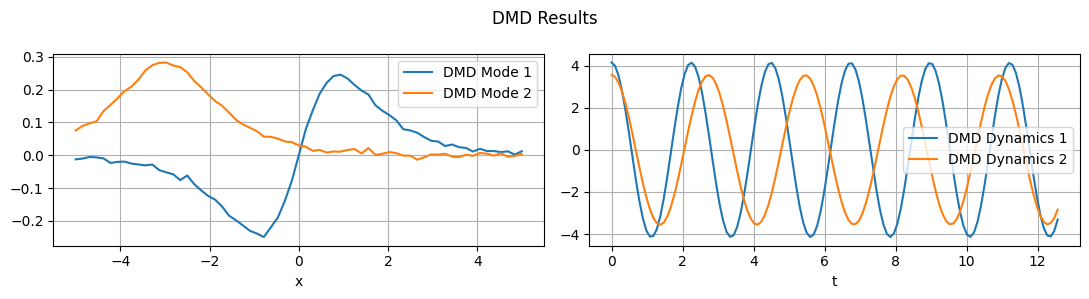

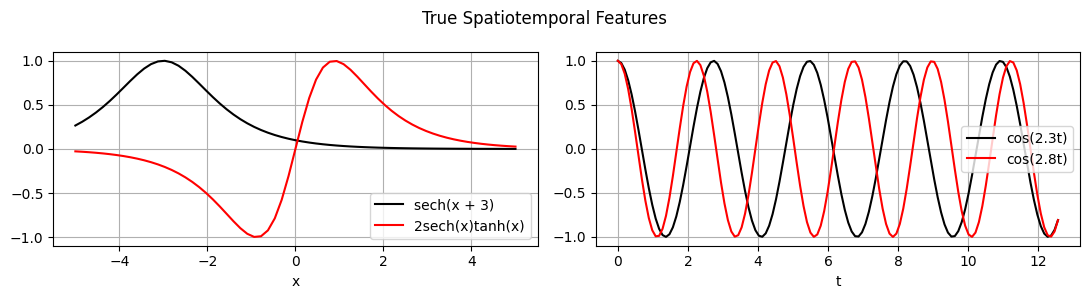

In [ ]:
plt.figure(figsize=(11, 3))
plt.suptitle("DMD Results")
plt.subplot(1, 2, 1)
# PLOT THE MODES HERE
plt.plot(x, dmd.modes[:, 0].real, label="DMD Mode 1")
plt.plot(x, dmd.modes[:, 1].real, label="DMD Mode 2")
# ^^^^^^^^^^^^^^^^^^^
plt.xlabel("x")
plt.legend()
plt.grid()
plt.subplot(1, 2, 2)
# PLOT THE DYNAMICS HERE
plt.plot(t, dmd.dynamics[0].real, label="DMD Dynamics 1")
plt.plot(t, dmd.dynamics[1].real, label="DMD Dynamics 2")
# ^^^^^^^^^^^^^^^^^^^^^^
plt.xlabel("t")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# True feature plotting for reference:
plt.figure(figsize=(11, 3))
plt.suptitle("True Spatiotemporal Features")
plt.subplot(1, 2, 1)
plt.plot(x, 1.0 / np.cosh(x + 3), c="k", label="sech(x + 3)")
plt.plot(x, 2.0 / np.cosh(x) * np.tanh(x), c="r", label="2sech(x)tanh(x)")
plt.xlabel("x")
plt.legend()
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(t, np.cos(2.3 * t), c="k", label="cos(2.3t)")
plt.plot(t, np.cos(2.8 * t), c="r", label="cos(2.8t)")
plt.xlabel("t")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

You will find that the columns of `modes` capture spatial features of the data and hence share the same dimensions as our input data snapshots. Conversely, the rows of `dyanmics` are time trajectories, where the ith time trajectory shows how the intensity of the ith spatial mode varies across time. Combined, these spatial mode time dynamic pairs form what we call _spatiotemporal modes_.

### **Exercise 3:**

Print the `amplitudes` attribute of our fitted DMD model.

Note that this attribute refers to the entries of the vector $\mathbf{b}$.
- Which spatiotemporal mode contributes more to the data?

In [ ]:
# TODO:
print(dmd.amplitudes)

[4.14738656 3.55887026]


### **Data reconstructions**

When added all together, the sum of all of the computed spatiotemporal modes forms our estimate of the training data set.

Although we could compute and add up these modes ourselves, PyDMD already does this. Fitted PyDMD models possess a `reconstructed_data` attribute, which uses the computed DMD modes and dynamics to reconstruct the data.

Below, we visualize the reconstruction and print the reconstruction error that results from our fit.

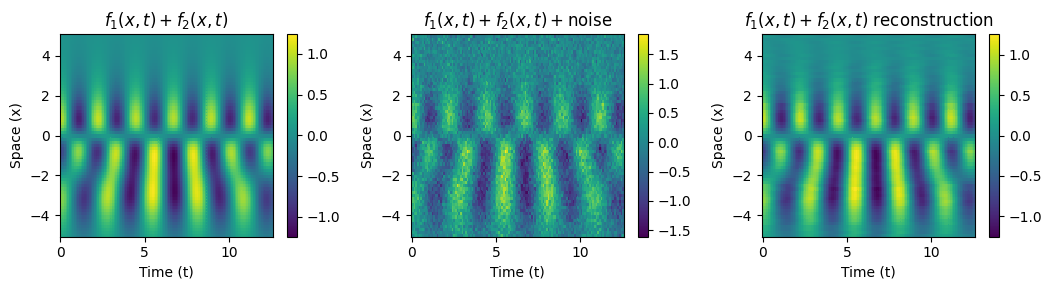

DMD reconstruction error: 5.294256379536873%


In [ ]:
# Visualize the reconstructed data.
titles = [
    "$f_1(x,t)+f_2(x,t)$",
    "$f_1(x,t)+f_2(x,t)+$noise",
    "$f_1(x,t)+f_2(x,t)$ reconstruction",
]
data = [X, X_noisy, dmd.reconstructed_data]

fig = plt.figure(figsize=(14, 3))
for i, (title, d) in enumerate(zip(titles, data)):
    plt.subplot(1, 4, i + 1)
    plt.title(title)
    plt.pcolor(tgrid, xgrid, d.real.T)
    plt.xlabel("Time (t)")
    plt.ylabel("Space (x)")
    plt.colorbar()

plt.tight_layout()
plt.show()

print(f"DMD reconstruction error: {compute_error(dmd.reconstructed_data, X)}%")

### **Summary plotting**

We have now examined all of the key components of the DMD representation. Nice!

However, instead of grabbing all of these attributes individually, you can visualize all of these attributes at once with a simple call to the `plot_summary` function found in the `pydmd.plotter` suite. We demonstrate a simple call to this function below. Note that the function requires a fitted PyDMD model, along with any necessary or relevant plotting parameters. [[source]](https://github.com/PyDMD/PyDMD/blob/7f4aa774b718c7ff57f2573b72420291e3bcd3a4/pydmd/plotter.py#L537)

Notice that on top of plotting our eigenvalues, modes, and dynamics, `plot_summary` also gives us the following:
- The singular value spectrum of the data matrix $\mathbf{X}$ is provided. From this, we can tell that this data requires a decomposition with $r = 2$.
- Eigenvalues, modes, and dynamics are color-coordinated to indicate the pairings that make up each spatiotemporal mode.
- Eigenvalue marker sizes reflect the corresponding amplitude of the spatiotemporal mode.

/usr/local/lib/python3.12/dist-packages/pydmd/plotter.py:699: UserWarning: Provided DMD model has less than 3 modes.Plotting all available modes...
  warnings.warn(


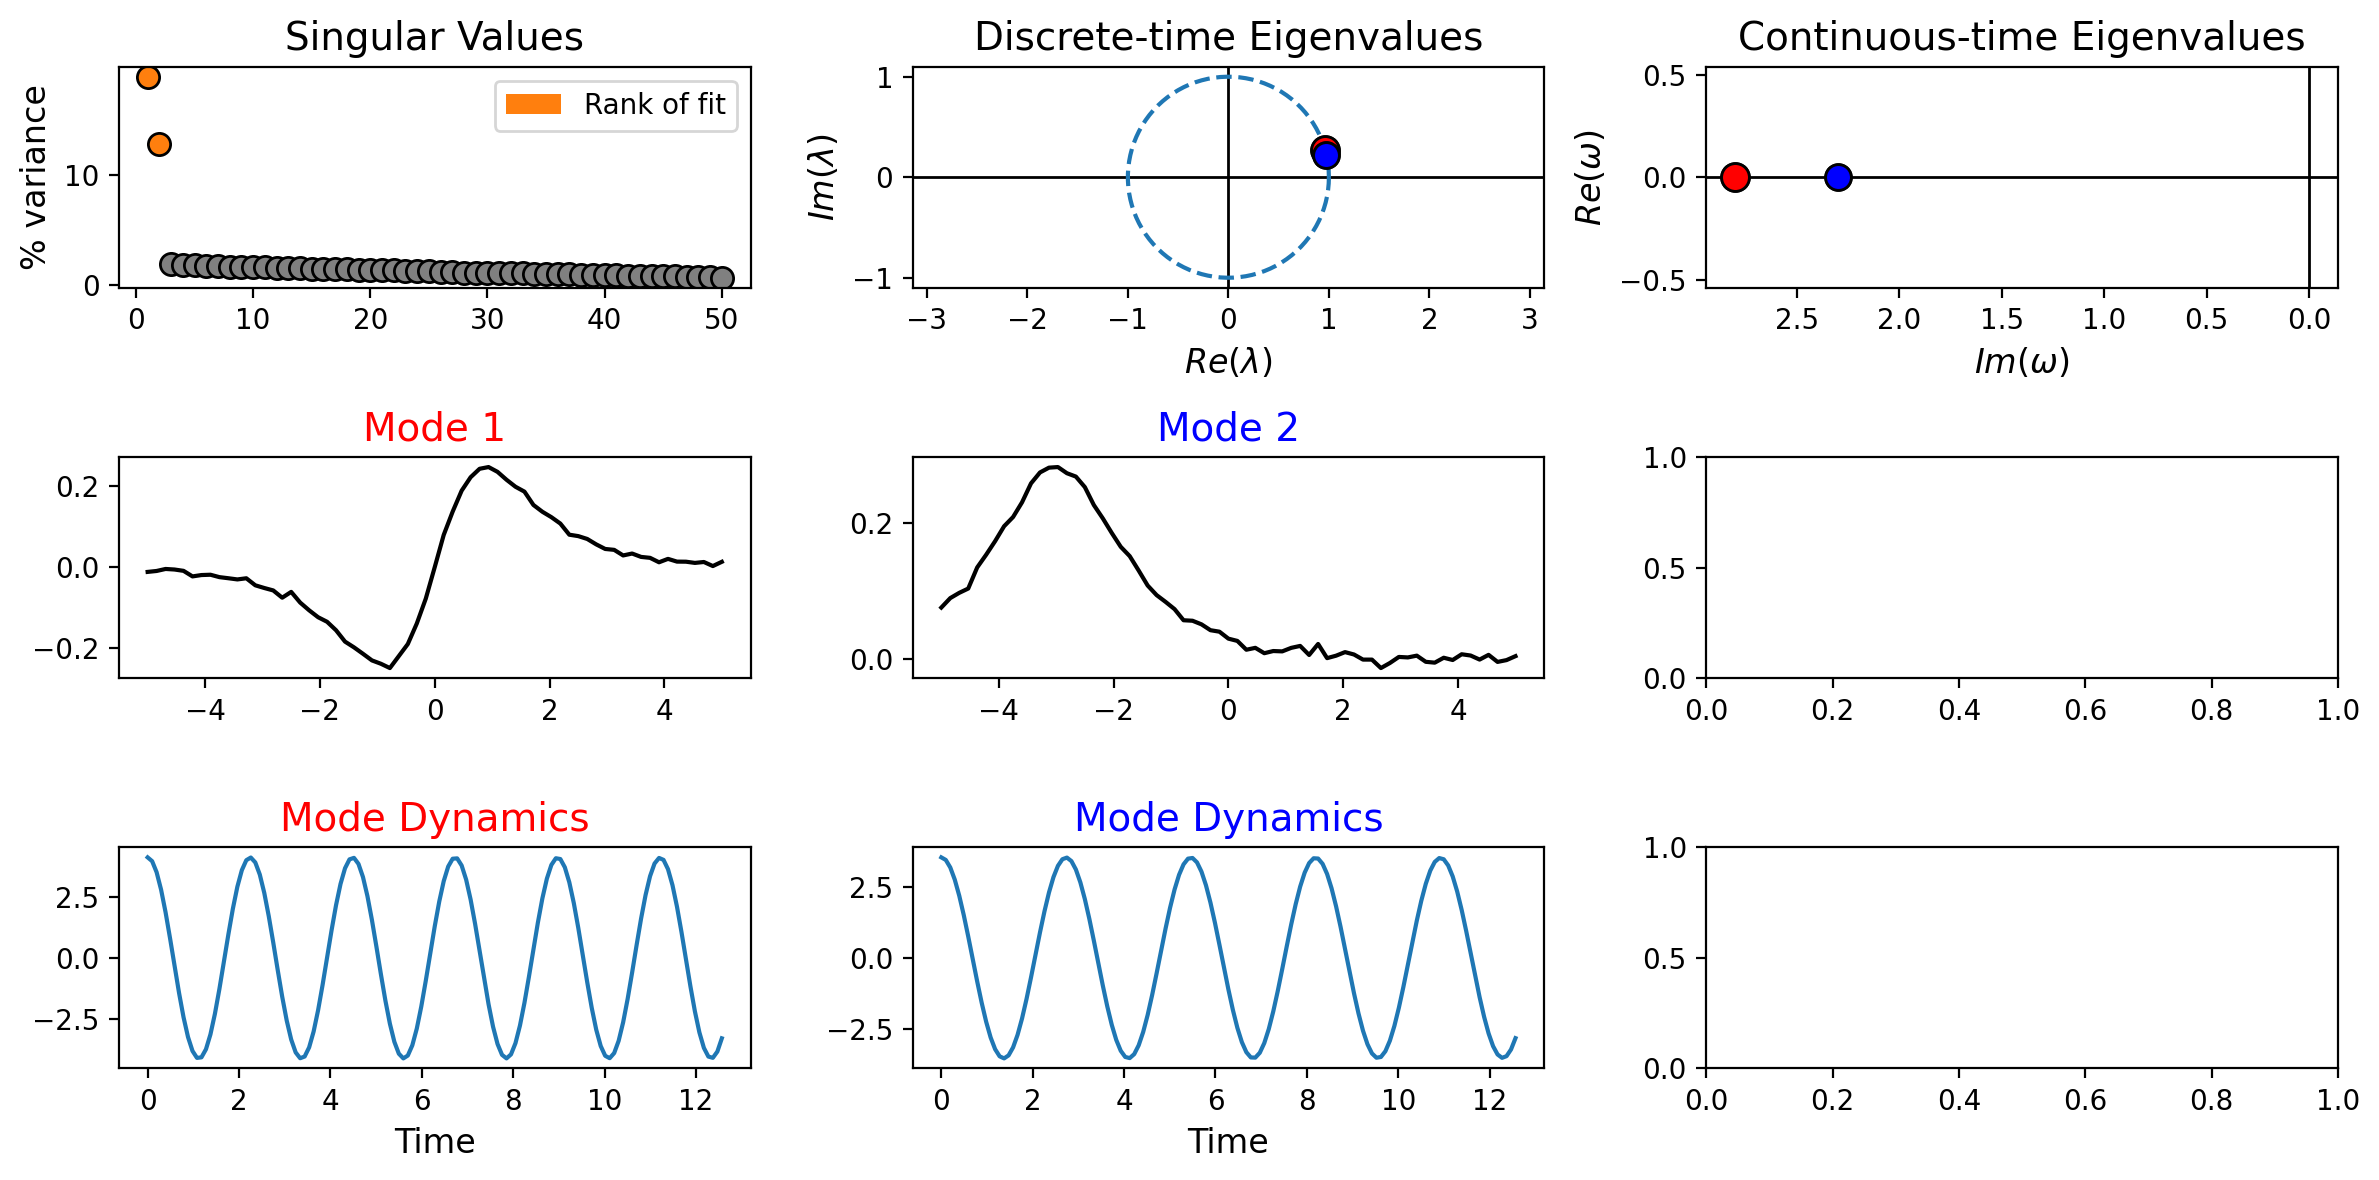

In [ ]:
from pydmd.plotter import plot_summary

plot_summary(
    dmd,  # fitted PyDMD model
    x=x,  # define the spatial grid
    t=t,  # define the temporal grid
    figsize=(12, 6),  # set the figure size
    flip_continuous_axes=True,  # flip the continuous-time eig plot axes
)

### **A more advanced model**

Under the hood, `BOPDMD` is solving nonlinear least-squares optimization problems in order to perform DMD. Because of this, we can tinker with even more attributes of the model:
- Set `num_trials=k` to perform multiple trials of DMD.
- Set `trial_size` to control the amount of data to use per trial.
- Set `eig_constraints` to constrain the eigenvalue structure.

For instance, we might want to constrain our model so that our eigenvalues are purely imaginary. We might also want to perform multiple trials of the optimization in hopes of obtaining a model that is more accurate. If so, we might build a model like the following:

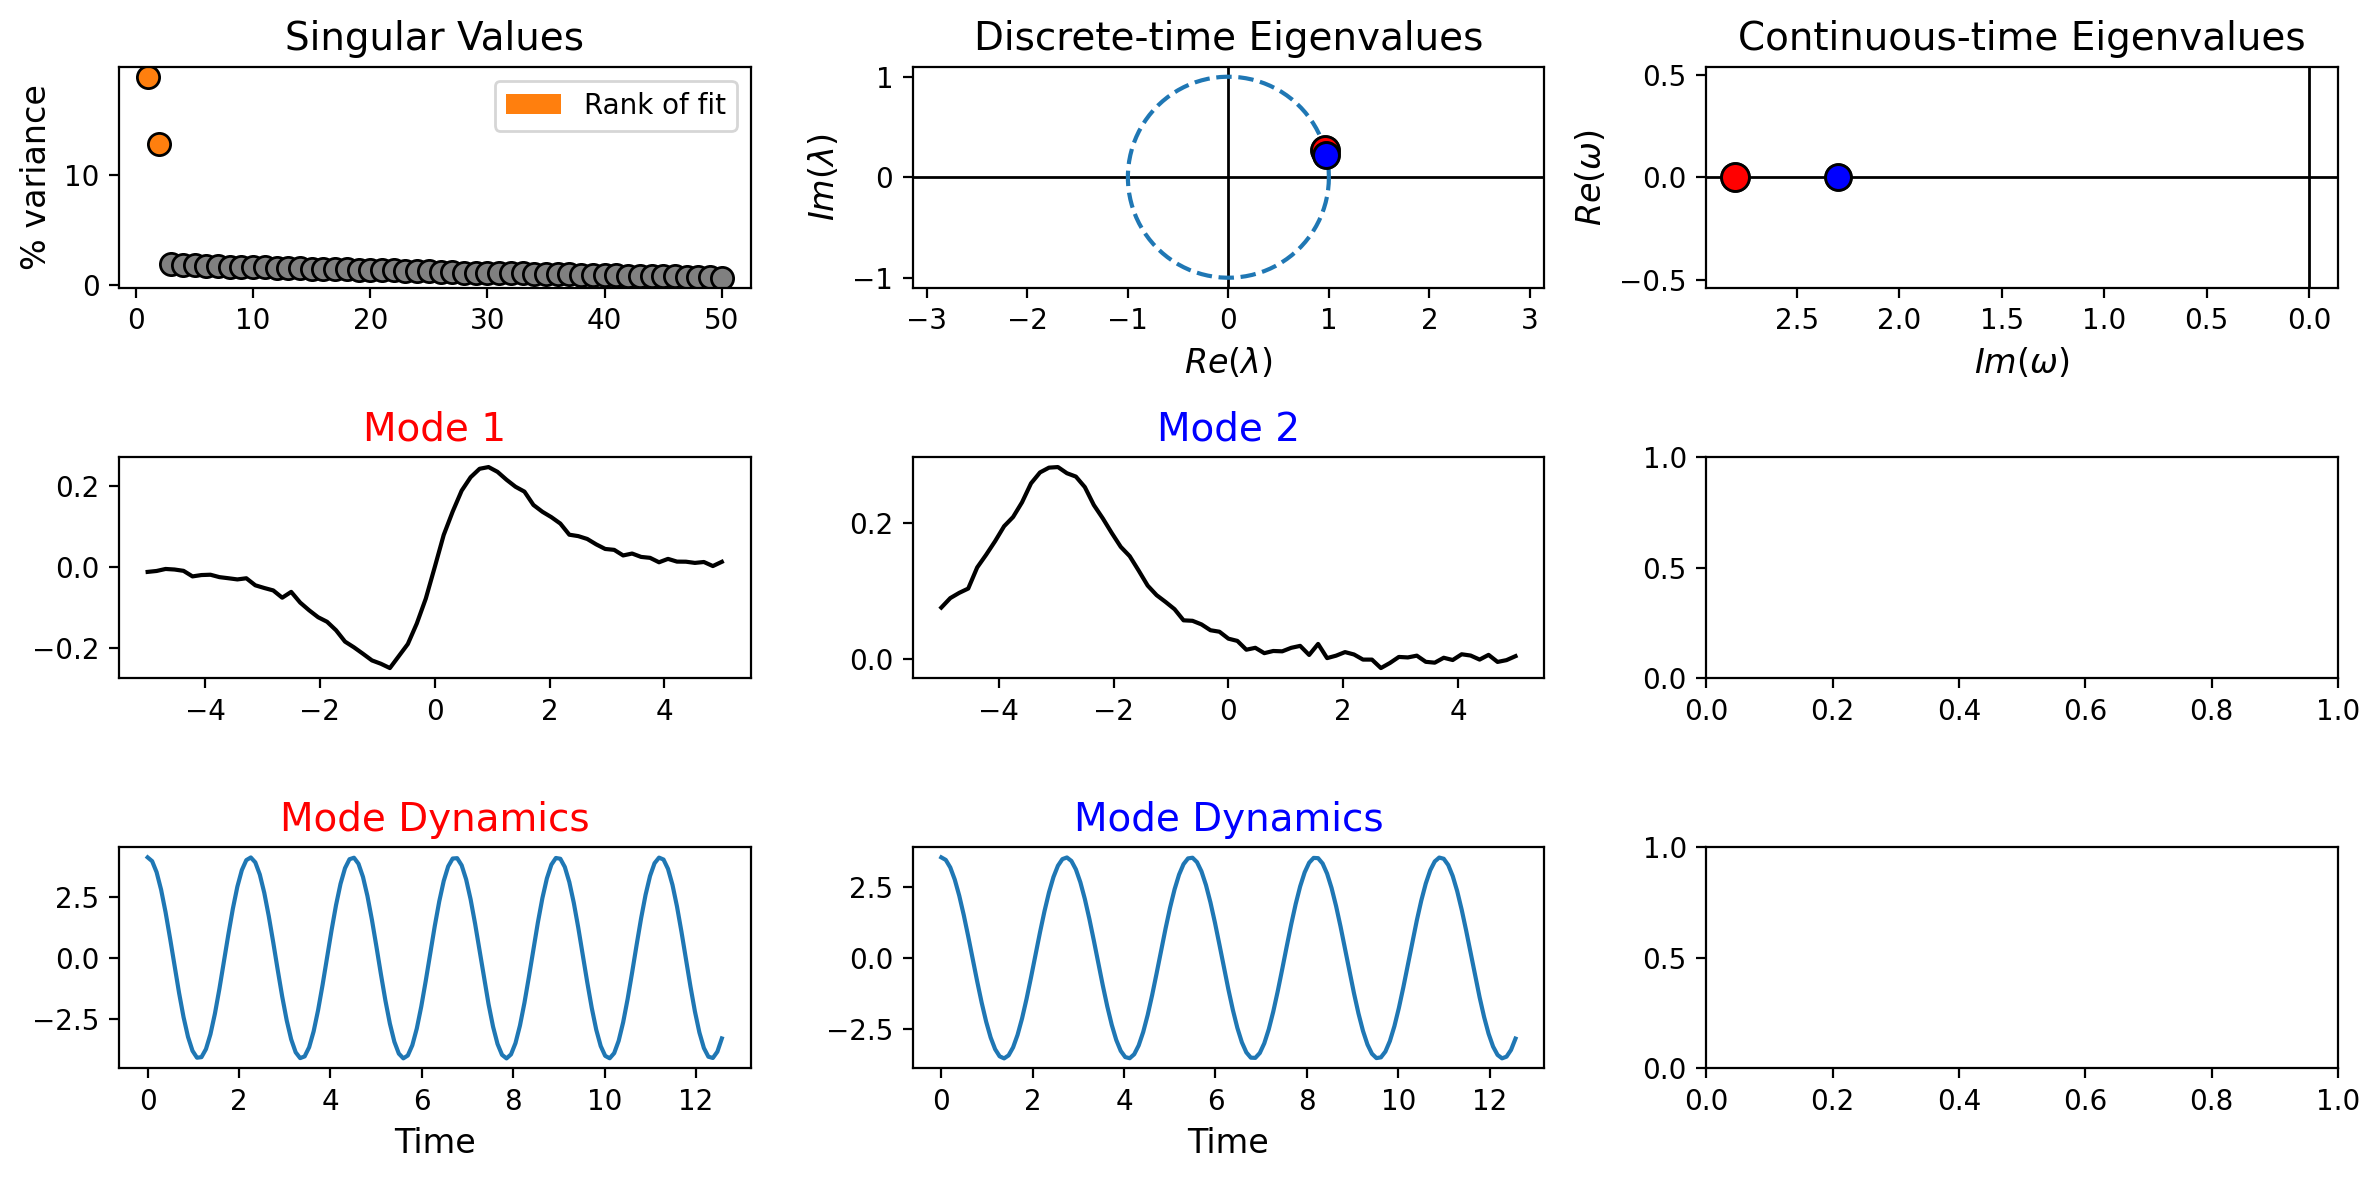

DMD reconstruction error: 5.291748254476281%


In [ ]:
# Build a BOP-DMD model with 2 spatiotemporal modes, and 100 bagging trials,
# where each trial uses 80% of the total number of snapshots per trial.
dmd = BOPDMD(
    svd_rank=2,
    num_trials=100,
    trial_size=0.8,
    # Constrain the eigenvalues to be imaginary.
    eig_constraints={"imag"},
)
# Perform the rest of the DMD fitting pipeline:
dmd.fit(X_noisy, t)
plot_summary(
    dmd,
    x=x,
    t=t,
    figsize=(12, 6),
    flip_continuous_axes=True,
)
print(f"DMD reconstruction error: {compute_error(dmd.reconstructed_data, X)}%")

## **Bonus exercises:**
- Reformat the `plot_summary` output. [[source]](https://github.com/PyDMD/PyDMD/blob/7f4aa774b718c7ff57f2573b72420291e3bcd3a4/pydmd/plotter.py#L537)
    - Adjust the size and the resolution of the figure.
    - Plot the singular values with log scaling on the y-axis.
    - Interchange the axes on the continuous-time eigenvalue plot.
    - Change the color of the eigenvalue markers from `"r"`, `"b"` to `"m"`, `"c"`.
- Perform DMD on this data set with rank $r=1$. Are we still able to represent the data with DMD? Why or why not?
- Perform DMD on this data set with rank $r=3$. Are we still able to represent the data with DMD? Why or why not?

In [ ]:
# Bonus exercise workspace:

For more information, see our full set of [tutorials](https://github.com/PyDMD/PyDMD/tree/master/tutorials) and our [arXiv paper](https://doi.org/10.48550/arXiv.2402.07463).